Before you begin, execute this cell to import numpy and packages from the D-Wave Ocean suite, and all necessary functions for the gate-model framework you are going to use, whether that is the Forest SDK or Qiskit. In the case of Forest SDK, it also starts the qvm and quilc servers.

In [1]:
%run -i "assignment_helper.py"
%matplotlib inline

Available frameworks:
Qiskit
D-Wave Ocean


In [2]:
import numpy as np

# Classical probability distributions

**Exercise 1** (1 point). Recall that in classical con flipping, get heads with probability $P(X=0) = p_0$ and tails with $P(X=1) = p_1$ for each toss of the coin, where $p_i\geq 0$ for all $i$, and the probabilities sum to one: $\sum_i p_i = 1$. Create a sample with a 1000 data points using numpy, with a probability of getting tails being 0.3. This is the parameter that the `binomial` function takes. Store the outcome in an array called `x_data`.

In [3]:
n_samples = 1000
p_1 = 0.3
x_data = np.random.binomial(1, 0.3, 1000)

In [4]:
assert isinstance(x_data, np.ndarray)
assert abs(p_1-x_data.sum()/n_samples) < 0.05

**Exercise 2** (1 point). As you recall, we may also write the probability distribution as a stochastic vector $\vec{p} = \begin{bmatrix} p_0 \\ p_1 \end{bmatrix}$. The normalization constraint on the probability distribution says that the norm of the vector is restricted to one in the $l_1$ norm. In other words, $||\vec{p}||_1 = \sum_i |p_i| = 1$. This would be the unit circle in the $l_1$ norm, but since $p_i\geq 0$, we are restricted to a quarter of the unit circle, just as we plotted above. Write a function that checks whether a given two-dimensional vector is a stochastic vector. That is, it should return `True` if all elements are positive and the 1-norm is approximately one, and it should return `False` otherwise. The input of the function is a numpy array.

In [5]:
def is_stochastic_vector(p: np.array):
    return all(i > 0 for i in p) and p.sum() == 1.0


In [6]:
assert not is_stochastic_vector(np.array([0.2, 0.3]))
assert not is_stochastic_vector(np.array([-0.2, 0.7]))
assert is_stochastic_vector(np.array([0.2, 0.8]))

**Exercise 3** (1 point). The probability of heads is just the first element in the $\vec{p}$ and we can use a projection to extract it. For the first element of the stochastic vector, the projection is described by the matrix $\begin{bmatrix} 1 & 0\\0 & 0\end{bmatrix}$. Write a function that performs this projection on a two-element vector described by a numpy array. Your output after the projection is also a two-element vector.

In [7]:
def project_to_first_basis_vector(p: np.array):
    return p * np.matrix([[1., 0.], [0., 0.]])


In [8]:
assert np.alltrue(project_to_first_basis_vector(np.array([0.2, 0.3])) == np.array([0.2, 0.]))
assert np.alltrue(project_to_first_basis_vector(np.array([1., 0.])) == np.array([1., 0.]))

**Exercise 4** (1 point). The projection operators introduce some linear algebra to working with probability distributions. We can also use linear algebra to transform one probability distribution to another. A left *stochastic matrix* will map stochastic vectors to stochastic vectors when multiplied from the left: its columns add up to one. Write a function that takes a matrix and a vector as input arguments (both are numpy arrays), checks whether the vector is a stochastic vector and whether the matrix is left stochastic. If they are, return the matrix applied to the vector, otherwise raise a `ValueError`. You can call the function `is_stochastic_vector` that you defined above.

In [9]:
def is_2D_matrix_stochastic(M: np.matrix):
    # checks the columns add up to 1
    return all(i == 1. for i in M.sum(axis=0).tolist()[0])
    
def apply_stochastic_matrix(p: np.array, M: np.array):
    """Apply the matrix M to the vector p, but only if
    p is a stochastic vector and M is a left stochastic
    matrix. Otherwise raise a ValueError.
    """
    M = np.matrix(M)
    # print(M.sum(axis=0).tolist()[0] )
    if is_stochastic_vector(p) and is_2D_matrix_stochastic(M):
        return M * p
    else:
        raise ValueError('wrong inputs')

In [10]:
p = np.array([[.5], [.5]])
M = np.array([[0.7, 0.6], [0.3, 0.4]])
assert abs(np.linalg.norm(apply_stochastic_matrix(p, M), ord=1)-1) < 0.01
M = np.array([[0.7, 0.6], [0.3, 0.5]])
try:
    apply_stochastic_matrix(p, M)
except ValueError:
    pass
else:
    raise AssertionError("did not raise")

**Exercise 5** (1 point). Create a left stochastic matrix in a variable called `M` that transforms the uniform distribution $\vec{p}= \begin{bmatrix} 0.5 \\ 0.5 \end{bmatrix}$ to $\begin{bmatrix} 0.6 \\ 0.4 \end{bmatrix}$. `M` should be a two-dimensional numpy array.

In [11]:
M = np.array([[0.6, 0.6], [0.4, 0.4]])

In [12]:
assert np.allclose(M.dot(np.array([0.5, 0.5])), np.array([0.6, 0.4]))

**Exercise 6** (1 point). Calculate the entropy of this distribution $\begin{bmatrix} 0.6 \\ 0.4 \end{bmatrix}$ in a variable called `S`.

In [13]:
p_0 = 0.6
p_1 = 0.4
S = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
print(S)

0.9709505944546686


In [14]:
###
### AUTOGRADER TEST - DO NOT REMOVE
###


# Quantum states

**Exercise 7** (1 point). A quantum state is a probability distribution. A qubit state is a distribution over two values, similar to the coin flipping in the classical state. A major difference is that the entries are complex numbers and the normalization is in the $l_2$ norm. Create a function similar to `is_stochastic_vector` that checks whether a vector is a valid quantum state. The input is a numpy array and the output should be boolean.

In [15]:
import math

def is_quantum_state(psi: np.array):
    return (1 - np.sqrt(sum([abs(i)**2 for i in psi])) ) < 0.0001


In [16]:
assert is_quantum_state(np.array([1/np.sqrt(2), 1/np.sqrt(2)]))
assert is_quantum_state(np.array([-1/np.sqrt(2), 1/np.sqrt(2)]))
assert is_quantum_state(np.array([-1/3, 2*np.sqrt(2)/3]))
assert is_quantum_state(np.array([-1j/3, 2*np.sqrt(2)/3]))
assert not is_quantum_state(np.array([0.2, 0.8]))

**Exercise 8** (1 point). While working with numpy arrays is convenient, it is better to use a framework designed for quantum computing, since it often allows us to execute a circuit directly on a quantum computer. In your preferred framework, implement a circuit of a single qubit with no operation on it. You should create it in an object called `circuit`. Do not add a measurement. The evaluation will automatically branch according to which framework you chose.

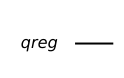

In [17]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
%config InlineBackend.figure_format = 'svg' # For Jupyter Notebooks


circuit = QuantumCircuit()
qr = QuantumRegister(1,'qreg')

circuit.add_register(qr)

circuit.draw(output='mpl')


In [18]:
amplitudes = get_amplitudes(circuit)
assert abs(amplitudes[0]-1.0) < 0.01

**Exercise 9** (1 point). In the execution branching above, you see that we use the wavefunction simulator. This allows us to use the probability amplitudes as usual numpy arrays, as you can see above. If we ran the circuit on an actual quantum device, we would not be able to inspect the wavefunction, but we would have to rely on the statistics of measurements to understand what is happening in the circuit.

Create a circuit in your preferred framework that creates an equal superposition in a qubit using a Hadamard gate. Again, the name of the object should be `circuit`. The evaluation will be based on measurement statistics. In this case, you should explicitly specify the measurement on the qubit

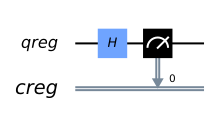

In [19]:
cr = ClassicalRegister(1,'creg')
circuit.add_register(cr)

circuit.h(qr[0])
circuit.measure(qr[0], cr[0])

circuit.draw(output='mpl')


In [20]:
counts = get_counts(circuit)
assert abs(counts['0']/100-.5) < 0.2

**Exercise 10** (1 point). If you plotted the state before measurement on the Bloch sphere, it would have been on the equator halfway between the $|0\rangle$ and $|1\rangle$ states, and the tip of the X axis. If you apply the Hadamard on the $|1\rangle$, it would have been the point on the opposite and of the X axis, since the resulting superposition would have had a -1 amplitude for $|1\rangle$. The measurement statistics, however, would be identical. The negative sign plays a role in interference: for instance, applying a Hadamard again, would take you back to $|1\rangle$. **Create the superposition after applying the Hadamard gate on $|1\rangle$.** We will verify whether it picked up the phase. Do not include a measurement, since we will inspect the wavefunction.

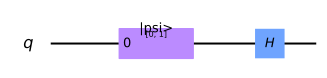

In [30]:
circuit = QuantumCircuit(1)

initial_state = [0,1]   # Define initial_state as |1>
circuit.initialize([0,1], 0) # Initialise to the 0th qubit to |1>

circuit.h(0)

circuit.draw(output='mpl')


In [31]:
amplitudes = get_amplitudes(circuit)
assert abs(amplitudes[1]+np.sqrt(2)/2) < 0.01

# More qubits and entanglement

**Exercise 11** (1 point). To get a sense of multiqubit states, it is important to be confident with the tensor product operation. Create a function that returns the four basis vectors, $|00\rangle$, $|01\rangle$, $|10\rangle$, and $|11\rangle$, of the tensor product space $\mathbb{C}^2\otimes\mathbb{C}^2$. The order in which they appear does not matter. The return value should be a list of four numpy arrays.

In [34]:
def create_canonical_basis():
    q0 = np.array([[1], [0]])
    q1 = np.array([[0], [1]])
    return np.array([np.kron(q0, q1), np.kron(q0, q0), np.kron(q1, q0), np.kron(q1, q1)])


In [35]:
basis = create_canonical_basis()
assert len(basis) == 4
if basis[0].shape != (4, ):
    basis = [basis_vector.reshape((4, )) for basis_vector in basis]
###
### AUTOGRADER TEST - DO NOT REMOVE
###


**Exercise 12** (1 point). A generic product state has the form  $\begin{bmatrix}a_0b_0\\ a_0b_1\\ a_1b_0\\ a_1b_1\end{bmatrix}=a_0b_0|00\rangle + a_0b_1|01\rangle + a_1b_0|10\rangle + a_1b_1|11\rangle$ on $\mathbb{C}^2\otimes\mathbb{C}^2$, but not all. We can use the basis vectors to form vectors in the space that do not have a product structure. These are entangled states that show strong correlations. Entanglement is an important resource in quantum computing and being able to create a circuit that generates an entangled state is critical. **Implement a `circuit` in your preferred framework to create the $|\phi^-\rangle = \frac{1}{\sqrt{2}}(|00\rangle-|11\rangle)$ state, that is, almost the same as the $|\phi^+\rangle$ state, but with the opposite sign of the probability amplitude of $|11\rangle$.** Do not include a measurement, as we will verify the state with the wavefunction simulator

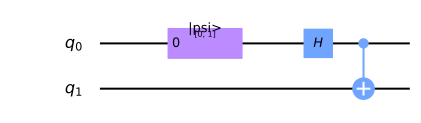

In [41]:
circuit = QuantumCircuit(2)
circuit.initialize([0,1], 0) # Initialise to the 0th qubit to |1>
circuit.h(0)
circuit.cx(0, 1)

circuit.draw(output='mpl')



In [42]:
amplitudes = get_amplitudes(circuit)
assert np.allclose(np.array([np.sqrt(2)/2, 0, 0, -np.sqrt(2)/2]), amplitudes)